In [143]:
import sys

import torch

torch.set_default_dtype(torch.float64)

sys.path.append('../Packages')
from torch.utils.data import DataLoader, Dataset
from skimage import filters
from tqdm.notebook import tqdm as tqdm
from model import *
from plot import *
import os
import Packages.algo.geodesic as geo
import Packages.algo.euler as euler

from Packages.disp.vis import *
from Packages.util import riemann, tensors
from pathlib import Path

%matplotlib inline

In [144]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, vector_fields, masks):
        self.data_dir = data_dir
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.sample = {
            'vector_field': torch.cat(
                [
                    vector_field.permute(2, 0, 1).to(device).float() * 1000.0
                    for vector_field in vector_fields
                ],
                dim=0
            ), 'masks': [
                mask.permute(1, 0).float().to(device).unsqueeze(0)
                for mask in masks
            ]
        }

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.sample


def matrix_exp_2d(A):
    """
    Construct positive definite matrix from symmetric matrix field A
    Args:
        A, torch.Tensor
    Returns:
        psd, torch.Tensor
    """
    I = torch.zeros_like(A, device='cpu')
    I[..., 0, 0] = 1
    I[..., 1, 1] = 1

    s = ((A[..., 0, 0] + A[..., 1, 1]) / 2.).unsqueeze(-1).unsqueeze(-1)
    q = torch.sqrt(-torch.det(A - torch.mul(s, I))).unsqueeze(-1).unsqueeze(-1)

    psd = torch.exp(s) * (torch.mul((torch.cosh(q) - s * torch.sinh(q) / q), I) + torch.sinh(q) / q * A)
    return psd


def pde(u, vector_lin, mask, differential_accuracy=2):
    s = tensors.lin2mat(u)
    metric_mat = matrix_exp_2d(s)
    nabla_vv = riemann.covariant_derivative_2d(vector_lin, metric_mat, mask,
                                               differential_accuracy=differential_accuracy)

    return nabla_vv

In [145]:
mode = 'cpu'
device = torch.device('cpu')
torch.set_default_dtype(torch.float64)

In [146]:
input_dir = '../Brains'
output_dir = f'../Checkpoints/braid'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [147]:
def load_2_braid(input_dir):
    name = 'sin'
    mask1 = torch.from_numpy(
        sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{name}/{name}_filt_mask.nhdr'))).double()
    boundary_mask = torch.where(torch.from_numpy(filters.laplace(mask1.cpu().numpy())) > 0, 1, 0)
    mask1 = mask1 - boundary_mask
    mask1 = mask1.to(device)

    name = 'cos'
    mask2 = torch.from_numpy(
        sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{name}/{name}_filt_mask.nhdr'))).double()

    boundary_mask = torch.where(torch.from_numpy(filters.laplace(mask2.cpu().numpy())) > 0, 1, 0)
    mask2 = mask2 - boundary_mask
    mask2 = mask2.to(device)

    name = 'sin'
    vector_field1 = torch.from_numpy(
        sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{name}/{name}_vector_field.nhdr'))).to(device)

    name = 'cos'
    vector_field2 = torch.from_numpy(
        sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{name}/{name}_vector_field.nhdr'))).to(device)

    return [vector_field1, vector_field2], [mask1, mask2], 2

In [148]:
def generate_2_braid():
    height, width = 100, 100

    vector_field1 = np.zeros((height, width, 2))
    vector_field2 = np.zeros((height, width, 2))
    mask1 = np.zeros((height, width))
    mask2 = np.zeros((height, width))

    for x in range(height):
        for k in range(0, 15):
            y1 = int(20 * np.sin(1 / (4 * np.pi) * x) + 41 + k)
            y2 = int(20 * np.cos(1 / (4 * np.pi) * (x - 60)) + 41 + k)
            vector_field1[x, y1, :] = np.array([1, 1 / (4 * np.pi) * 20 * np.cos(1 / (4 * np.pi) * x)])
            vector_field2[x, y2, :] = np.array([1, -1 / (4 * np.pi) * 20 * np.sin(1 / (4 * np.pi) * (x - 60))])
            mask1[x, y1] = 1
            mask2[x, y2] = 1

        range1 = np.where(mask1[x, :] == 1)[0]
        range2 = np.where(mask2[x, :] == 1)[0]
        mask1[x, range(min(range1), max(range1) + 1)] = 1
        mask2[x, range(min(range2), max(range2) + 1)] = 1

    vector_field1 = torch.from_numpy(vector_field1).to(device)
    vector_field2 = torch.from_numpy(vector_field2).to(device)
    mask1 = torch.from_numpy(mask1).to(device)
    mask2 = torch.from_numpy(mask2).to(device)

    return [vector_field1, vector_field2], [mask1, mask2], 2

In [149]:
vector_fields, masks, n_fields = load_2_braid(input_dir)
height, width = masks[0].shape

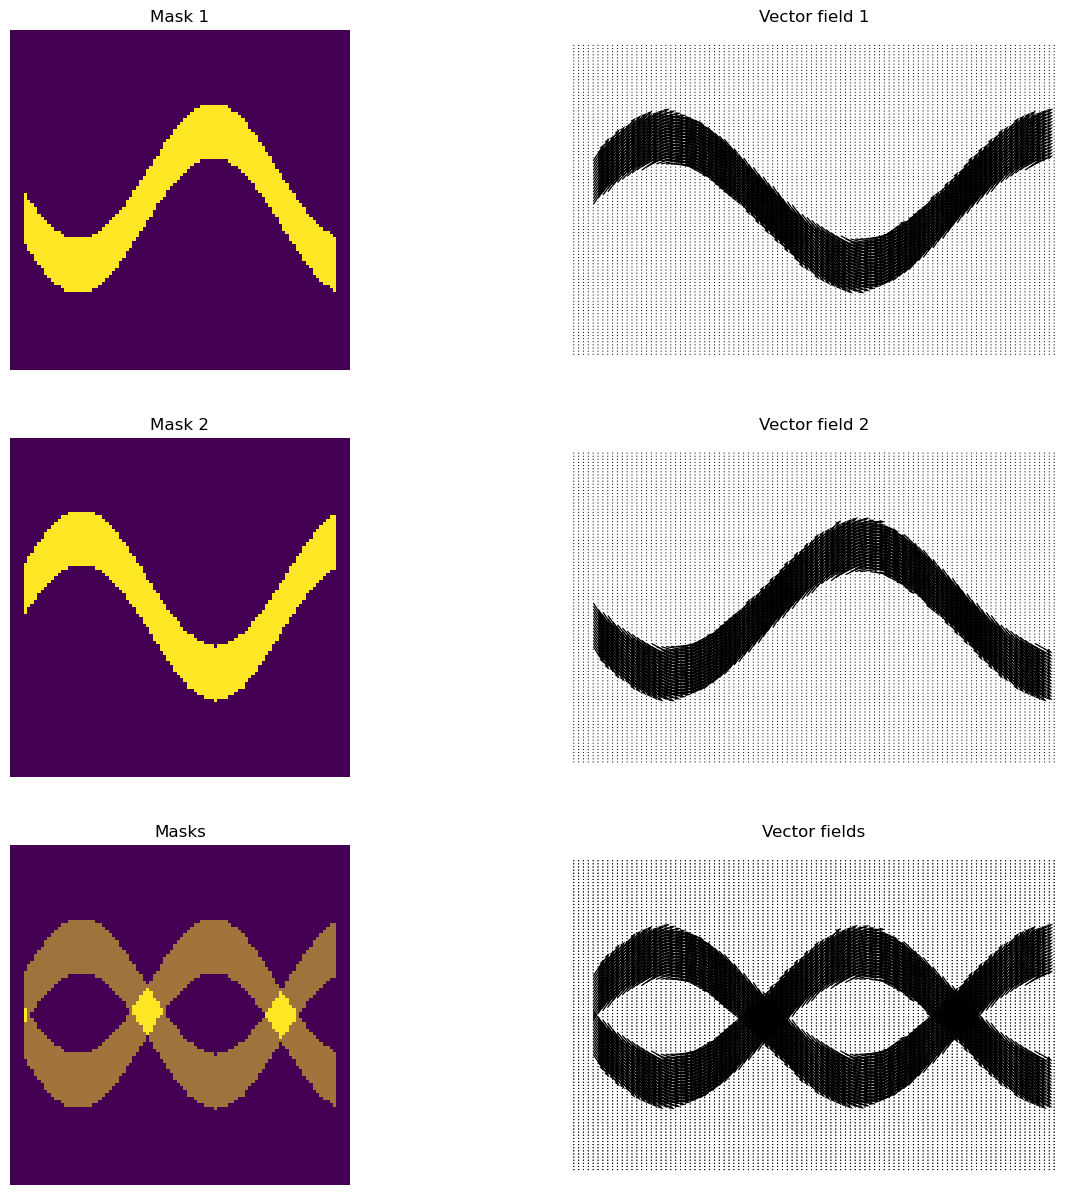

In [150]:
fig, axs = plt.subplots(n_fields + 1, 2, figsize=(15, 15))

x = np.linspace(0, height - 1, height)
y = np.linspace(0, width - 1, width)
yy, xx = np.meshgrid(x, y)

for ax in axs.ravel():
    ax.set_axis_off()

for i in range(n_fields):
    axs[i, 0].imshow(masks[i].numpy())
    axs[i, 0].set_title(f'Mask {i + 1}')
    axs[i, 1].quiver(
        xx,
        yy,
        vector_fields[i][:, :, 0].numpy() * masks[i].T.numpy(),
        vector_fields[i][:, :, 1].numpy() * masks[i].T.numpy()
    )
    axs[i, 1].set_title(f'Vector field {i + 1}')
    axs[-1, 0].imshow(masks[i], alpha=1 if i == 0 else 0.5)
    axs[-1, 1].quiver(
        xx,
        yy,
        vector_fields[i][:, :, 0].numpy() * masks[i].T.numpy(),
        vector_fields[i][:, :, 1].numpy() * masks[i].T.numpy()
    )

axs[-1, 0].set_title('Masks')
axs[-1, 1].set_title('Vector fields')

plt.show()

# Training

In [151]:
epoch_loss_list = []
epoch_num = 5000
start_epoch_num = 0
learning_rate = 1e-4

model = DenseED(
    in_channels=4,
    out_channels=3,
    imsize=100,
    blocks=[6, 8, 6],
    growth_rate=16,
    init_features=48,
    drop_rate=0,
    out_activation=None,
    upsample='nearest'
)
model.train()

criterion = torch.nn.MSELoss()
optimizer_id = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

dataset_id = ImageDataset(Path(input_dir), vector_fields, masks)

dataloader_id = DataLoader(dataset_id, batch_size=1, shuffle=True, num_workers=0)

# params 747147, # conv layers 28


In [ ]:
model = model.float()
for epoch in tqdm(range(start_epoch_num, start_epoch_num + epoch_num)):
    epoch_loss_id = 0

    for i, batched_id_sample in enumerate(dataloader_id):
        '''innerdomain backpropagate'''
        input_id = batched_id_sample['vector_field'].to(device).float()
        input_id.requires_grad = True
        # u_pred_id: [batch_size, *data_shape, feature_num] = [1, 3, ...]
        u_pred_id = model(input_id)
        # f_pred_id: [batch_size, feature_num, *data_shape] = [1, 2, ...]
        masks = [
            mask.squeeze()
            for mask in batched_id_sample['masks']
        ]

        pde_losses = [
            pde(u_pred_id.squeeze().double(), input_id[0, 2 * i:2 * (i + 1)].squeeze().double(), masks[i],
                differential_accuracy=2)
            for i in range(n_fields)
        ]

        f_preds = [
            torch.einsum('...ij,...ij->...ij', pde_loss, mask.unsqueeze(0).expand(2, -1, -1))
            for pde_loss, mask in zip(pde_losses, masks)
        ]

        f_pred_id = torch.cat(f_preds, 0)
        # f_true_id: [batch_size, feature_num, *data_shape] = [1, 2, ...]
        f_true_id = torch.zeros_like(f_pred_id)

        optimizer_id.zero_grad()
        loss_id = criterion(f_pred_id, f_true_id)
        loss_id.backward()
        epoch_loss_id += loss_id.item()
        optimizer_id.step()

    with open(f'{output_dir}/loss.txt', 'a') as f:
        f.write(f'{epoch_loss_id}\n')

    epoch_loss_list.append(epoch_loss_id)
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_id_state_dict': optimizer_id.state_dict(),
            'loss_id': epoch_loss_id
        }, f'{output_dir}/model.pth.tar')

  0%|          | 0/5000 [00:00<?, ?it/s]

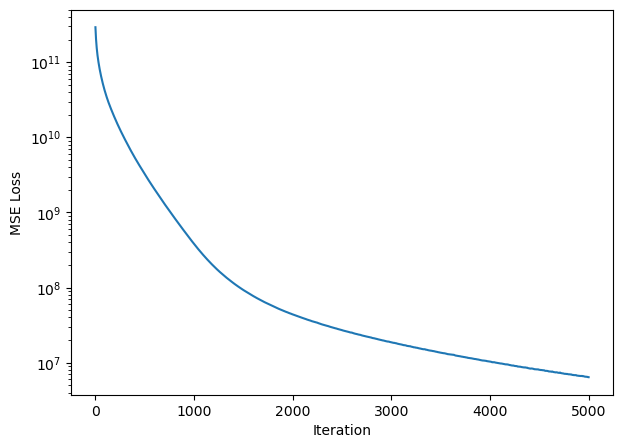

In [137]:
_, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel('Iteration')
ax.set_ylabel('MSE Loss')
ax.set_yscale('log')
ax.plot(epoch_loss_list)
plt.savefig(f'{output_dir}/adadelta_loss_{learning_rate}.png')

# Plotting

In [138]:
checkpoint = torch.load(f'{output_dir}/model.pth.tar')

model.load_state_dict(checkpoint['model_state_dict'])

mask = torch.where(torch.sum(torch.stack(masks), dim=0) > 0, 1, 0)
model = model.float()
u_pred = model(torch.cat([vector_field.permute(2, 0, 1).unsqueeze(0).float() for vector_field in vector_fields], 1))
u_pred = u_pred.squeeze()
s_pred = tensors.lin2mat(u_pred)

metric_pred_mat = matrix_exp_2d(s_pred)
metric_pred_lin = tensors.mat2lin(metric_pred_mat)

In [139]:
vector_lins = [
    vector_field.permute(2, 0, 1).numpy()
    for vector_field in vector_fields
]
tensor_pred_mat = np.linalg.inv(metric_pred_mat.detach().numpy())
tensor_pred_lin = tensors.mat2lin(tensor_pred_mat)

In [140]:
geo_delta_t, euler_delta_t = 5e-3, 5e-3
geo_iters, euler_iters = int(1e6), int(1e6)

In [141]:
start_coords = np.array([
    [60, 29],
    [60, 70]
])

paths = [
    euler.eulerpath_vectbase_2d_w_dv(vector_lin, mask, start_coord, euler_delta_t, iter_num=euler_iters,
                                     both_directions=True)
    + geo.geodesicpath('f', tensor_pred_lin, vector_lin, mask, start_coord,
                       vector_lin[:, start_coord[0], start_coord[1]], geo_delta_t, iter_num=geo_iters,
                       both_directions=True)
    for vector_lin, start_coord in zip(vector_lins, start_coords)
]


Euler starting eigenvector: [-0.99513281 -0.0985428 ]
Euler starting eigenvector: [0.99513281 0.0985428 ]
Shooting geodesic path from [60 29] with initial velocity [-0.99513281 -0.0985428 ]
Shooting geodesic path from [60 29] with initial velocity [0.99513281 0.0985428 ]
Euler starting eigenvector: [-1.  0.]
Euler starting eigenvector: [ 1. -0.]
Shooting geodesic path from [60 70] with initial velocity [-1.  0.]
Shooting geodesic path from [60 70] with initial velocity [ 1. -0.]


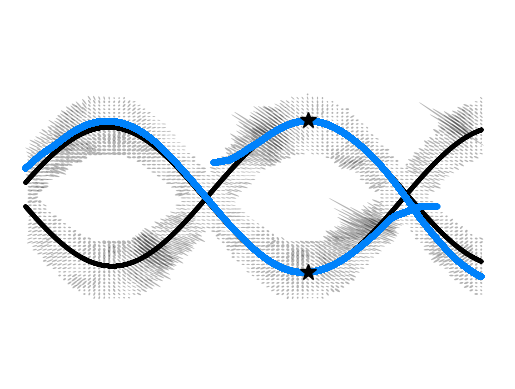

In [142]:

def disp_path(ax, x, y, label, color, size, alpha):
    ax.scatter(x[::1], y[::1], c=color, s=size, alpha=alpha, label=label, zorder=1)


fig, ax = plt.subplots()
tens_fig = vis_tensors(metric_pred_lin.cpu().detach().numpy() * np.stack((mask, mask, mask), 0), '', False, scale=8e-1,
                       opacity=0.3, show_axis_labels=False, ax=ax)
for eulx, euly, _, _ in paths:
    disp_path(ax, eulx, euly, label="integral curve on vector field", color='black', size=2, alpha=1)

for _, _, geox_pred, geoy_pred in paths:
    disp_path(ax, geox_pred, geoy_pred, label=f"geodesic on learned", color='#0082fb', size=10, alpha=1)

ax.plot(start_coords[:, 0], start_coords[:, 1], linestyle='', marker='*', color='black', markersize=12)